## Lab 5.3 - CNN for cats and dogs

Now that we have imported our custom image data, formatted them as proper feature and target numpy arrays, and split them between individual training and test data sets, we can use Keras to create another Convolutional Neural Network (CNN) and train it to classify images of cats and dogs (the holy grail of Arificial Intelligence!)

First, let's use the pickle library to bring in the data sets we generated in the previous part of the lab:

In [1]:
import pickle
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras import backend as K

K.set_image_dim_ordering('tf')
print "using ordering:", K.image_dim_ordering()

pickle_file = '-catsdogs.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    X_train = save['X_train']
    y_train = save['y_train']
    X_test = save['X_test']
    y_test = save['y_test']
    del save  # hint to help gc free up memory
    print('Training set', X_train.shape, y_train.shape)
    print('Test set', X_test.shape, y_test.shape)

Using TensorFlow backend.


using ordering: tf
('Training set', (14000, 64, 64), (14000, 1))
('Test set', (6000, 64, 64), (6000, 1))


Now that the data is imported, go through and implement the CNN from scratch based on the one developed in Lab 5.1. 

Experiment with different hyper-parameters as well as different architectures for your network. If you're not getting the results you want try a deeper network by adding more convolutional or fully connected layers. Remember that with CNN's, all convolutional layers should go in the beginning, and the fully connected layers should go at the end. You can also try to make the network 'wider' by adding more depth to each convolutional layer or more neurons to the fully connected layers. If you are noticing problems with over-fitting you can experiment with larger dropout rates or other regularlization strategies.

You can also experiment with filters of a larger size in the convolutional layers. Larger filters will capture more information in the image at the expense of longer training times. For more information about the tradeoffs between depth and width in a CNN, you can read this paper: 

https://arxiv.org/pdf/1409.1556.pdf

Known as the 'VGG paper', this research is currently one of the state-of-the-art benchmarks for image recognition using CNN's. The authors' hypothesis for the paper was that depth in a CNN (total number of layers) is much more important than the size of the filters or the depth within each convolutional layer. Thus they used very small filter sizes (only 3x3) but focused on making the networks as deep as possible. If you are still getting poor results and want to develop a deeper network, a good place to start would be to try to implement one of the networks from the 'VGG paper'. The deepest ones will probably take too long to train without having a dedicated graphics card, but you should be able to train one of the medium ones (for example network 'B') using just the virtual machine developed in the first lab.

Just like when we initially loaded the data, with large networks you again run the risk of overloading your RAM memory, which will either throw an error during model compilation or training, or cause your Python kernel to crash. If you run into these issues, try reducing the complexity of your network (either using less layers, or reducing the depth of each layer) or using a smaller mini-batch size. If you are using the virtual machine, your RAM will be quite limited so you will not be able to train very deep or complex networks. This is ok for the demonstration purposes of the class, but for your own work you may want to use a native installation of Python and the related libraries so that you can use the full potential of your computer.

Ofcourse classifying dogs and cats is a much more difficult problem than digit classification, so you should not expect to reach the same level of performance we did before. With an average sized network training over night on the virtual machine, you should be able to get at least 80% accuracy on the test dataset. Once you get a result you like, submit your work on this file as a pull request back to the main project.

In [2]:
## implement your CNN starting here.
num_classes = 2
img_rows, img_cols = X_train.shape[1],  X_train.shape[2]

print X_train.shape
print img_rows, img_cols

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

print X_train.shape
print y_train.shape


(14000, 64, 64)
64 64
(14000, 64, 64, 1)
(14000, 1)


(64, 64)
(14000, 1)


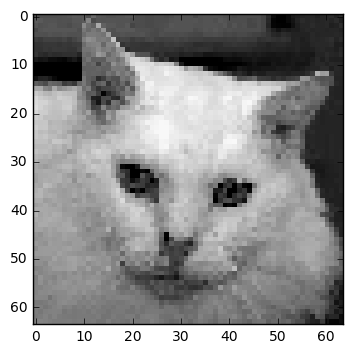

In [3]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

img_num = 0

if K.image_dim_ordering() == 'th':
    img = X_train[img_num][0,:,:]
else:
    img = X_train[img_num][:,:,0]

print img.shape
print y_train.shape
imshow(img, cmap = plt.get_cmap('gray'), vmin = 0, vmax = 1,  interpolation='nearest')

In [4]:
# model hyperparameters
batch_size = 128
nb_epoch = 30

# network architecture
patch_size_1 = 5
patch_size_2 = 5
patch_size_3 = 5


pool_size = 2

num_hidden_1 = 1000
num_hidden_2 = 1000
num_hidden_3 = 1000
dropout = 0.5



In [5]:
# create new Keras Sequential model
model = Sequential()

# add first convolutional layer to model and specify it's depth and filter size
# for the first layer we also have to specify the size of each input image
# which we calculated above
model.add(Convolution2D(64, 5, 5,
                        border_mode='valid',
                        input_shape=input_shape))
# apply 'relu' activation function for first layer
model.add(Activation('relu'))
# apply max pooling to reduce the size of the image by a factor of 2
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# repeat these operations for the second convolutional layer
# this time Keras can figure out the input size 
# from the previous layer on it's own
model.add(Convolution2D(128, 5, 5,border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))


model.add(Convolution2D(256, 5, 5,border_mode='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
# flatten the three-dimensional convolutional layer to a single layer of neurons
model.add(Flatten())

# add the first fully connected layer, applying 'relu' activation and dropout
model.add(Dense(num_hidden_1))
model.add(Activation('relu'))
model.add(Dropout(dropout))

# add the second fully connected layer
model.add(Dense(num_hidden_2))
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_hidden_3))
model.add(Activation('relu'))
model.add(Dropout(dropout))

# add the final classification layer with the number of neurons 
# matching the number of classes we are trying to learn
model.add(Dense(num_classes))

# apply the 'softmax' activation to the final layer to convert the output to 
# a probability distribution
model.add(Activation('softmax'))

In [6]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [7]:
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=1, validation_data=(X_test, Y_test))

Train on 14000 samples, validate on 6000 samples
Epoch 1/30
14000/14000 [==============================] - 1062s - loss: 0.6941 - acc: 0.5022 - val_loss: 0.6922 - val_acc: 0.5088
Epoch 2/30
14000/14000 [==============================] - 1054s - loss: 0.6912 - acc: 0.5367 - val_loss: 0.6792 - val_acc: 0.6110
Epoch 3/30
 9472/14000 [===================>..........] - ETA: 303s - loss: 0.6779 - acc: 0.5811

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)

print 'Test score:', score[0]
print 'Test accuracy: {:.2%}'.format(score[1])